In [ ]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import requests

import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

import openmeteo_requests
import requests_cache
from retry_requests import retry

In [ ]:
sensex = yf.download('^NSEI', start='2021-12-20', end='2023-12-31')
sensex.head(15)

sensex.shape

[*********************100%%**********************]  1 of 1 completed


(503, 6)

In [ ]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 28.6519,
	"longitude": 77.2315,
	"start_date": "2022-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "temperature_2m_min", "sunshine_duration", "precipitation_sum", "precipitation_hours", "wind_speed_10m_max"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 28.646747589111328°N 77.2748031616211°E
Elevation 231.0 m asl
Timezone b'Asia/Kolkata' b'IST'
Timezone difference to GMT+0 19800 s


In [ ]:
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(2).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(4).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe.head())
print(daily_dataframe.shape)

                       date  temperature_2m_max  temperature_2m_min  \
0 2021-12-31 18:30:00+00:00           18.020000                5.62   
1 2022-01-01 18:30:00+00:00           18.670000                6.62   
2 2022-01-02 18:30:00+00:00           19.970001                7.22   
3 2022-01-03 18:30:00+00:00           21.820002                7.77   
4 2022-01-04 18:30:00+00:00           15.070000               10.97   

   sunshine_duration  precipitation_sum  precipitation_hours  \
0       33673.980469           0.000000                  0.0   
1       32705.294922           0.000000                  0.0   
2       33360.726562           0.000000                  0.0   
3       25406.871094           0.000000                  0.0   
4           0.000000           9.000002                 13.0   

   wind_speed_10m_max  
0            9.114471  
1            8.714677  
2           10.308831  
3            9.504273  
4           19.453327  
(730, 7)


In [ ]:
non_zero_precipitation = daily_dataframe[(daily_dataframe['precipitation_sum'] != 0)]
print(non_zero_precipitation)

                         date  temperature_2m_max  temperature_2m_min  \
4   2022-01-04 18:30:00+00:00           15.070000               10.97   
5   2022-01-05 18:30:00+00:00           18.870001               11.87   
6   2022-01-06 18:30:00+00:00           19.770000               11.92   
7   2022-01-07 18:30:00+00:00           17.270000               13.87   
8   2022-01-08 18:30:00+00:00           17.520000               10.22   
..                        ...                 ...                 ...   
696 2023-11-27 18:30:00+00:00           20.320002               15.02   
697 2023-11-28 18:30:00+00:00           24.620001               13.27   
698 2023-11-29 18:30:00+00:00           21.520000               13.22   
699 2023-11-30 18:30:00+00:00           24.220001               13.92   
701 2023-12-02 18:30:00+00:00           24.470001               11.37   

     sunshine_duration  precipitation_sum  precipitation_hours  \
4             0.000000           9.000002                

In [ ]:
def calculate_rsi(data, window=10):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate Short and Long EMAs for each day
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD Line for each day
    macd = short_ema - long_ema

    # Calculate Signal Line for each day
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()

    return macd, signal_line

In [ ]:
def calculate_daily_change(data):
    # Calculate daily change
    data['Daily_Change'] = data['Close'] - data['Open']

    # Calculate percentage change
    data['Percentage_Change'] = (data['Daily_Change'] / data['Open']) * 100

    return data

In [ ]:
sensex['RSI'] = calculate_rsi(sensex)
sensex['MACD'], sensex['Signal_Line'] = calculate_macd(sensex)
sensex = calculate_daily_change(sensex)
sensex.head(15)

,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal_Line,Daily_Change,Percentage_Change
Date,,,,,,,,,,,
2021-12-20,16824.250000,16840.099609,16410.199219,16614.199219,16614.199219,330600,NaN,0.000000,0.000000,-210.050781,-1.248500
2021-12-21,16773.150391,16936.400391,16688.250000,16770.849609,16770.849609,241000,NaN,12.496327,2.499265,-2.300781,-0.013717
2021-12-22,16865.550781,16971.000000,16819.500000,16955.449219,16955.449219,207900,NaN,36.870384,9.373489,89.898438,0.533030
2021-12-23,17066.800781,17118.650391,17015.550781,17072.599609,17072.599609,197000,NaN,64.892022,20.477196,5.798828,0.033977
2021-12-24,17149.500000,17155.599609,16909.599609,17003.750000,17003.750000,182600,NaN,80.614510,32.504659,-145.750000,-0.849879
2021-12-27,16937.750000,17112.050781,16833.199219,17086.250000,17086.250000,144800,NaN,98.595211,45.722769,148.500000,0.876740
2021-12-28,17177.599609,17250.250000,17161.150391,17233.250000,17233.250000,176000,NaN,123.285559,61.235327,55.650391,0.323971
2021-12-29,17220.099609,17285.949219,17176.650391,17213.599609,17213.599609,161700,NaN,139.657332,76.919728,-6.500000,-0.037747
2021-12-30,17201.449219,17264.050781,17146.349609,17203.949219,17203.949219,320800,NaN,150.122852,91.560353,2.500000,0.014534


In [ ]:
dates_to_drop = [
    "2021-12-20", "2021-12-21", "2021-12-22", "2021-12-23", "2021-12-24",
    "2021-12-27", "2021-12-28", "2021-12-29", "2021-12-30", "2021-12-31"
]

# Convert list to datetime format
dates_to_drop = pd.to_datetime(dates_to_drop).date

# Filter out the rows with the specified dates
sensex = sensex[~sensex.index.isin(dates_to_drop)]

sensex.head(15)

,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal_Line,Daily_Change,Percentage_Change
Date,,,,,,,,,,,
2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,91.873627,202.799199,126.132137,238.548828,1.371983
2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,92.024840,241.616884,149.229086,123.849609,0.700451
2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,91.583032,278.848781,175.153025,105.150391,0.590066
2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500,77.407814,290.534215,198.229263,-22.599609,-0.127189
2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300,82.984678,301.707220,218.924854,15.099609,0.084841
2022-01-10,17913.300781,18017.449219,17879.150391,18003.300781,18003.300781,232400,84.363162,322.227423,239.585368,90.000000,0.502420
2022-01-11,17997.750000,18081.250000,17964.400391,18055.750000,18055.750000,220200,83.170652,338.816381,259.431571,58.000000,0.322263
2022-01-12,18170.400391,18227.949219,18128.800781,18212.349609,18212.349609,245000,86.272017,360.444549,279.634166,41.949219,0.230866
2022-01-13,18257.000000,18272.250000,18163.800781,18257.800781,18257.800781,303700,87.303139,376.907799,299.088893,0.800781,0.004386


In [ ]:
daily_dataframe.fillna(daily_dataframe.median(), inplace=True)


# Ensure correct data types
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])
daily_dataframe['temperature_2m_max'] = daily_dataframe['temperature_2m_max'].astype(float)
daily_dataframe['temperature_2m_min'] = daily_dataframe['temperature_2m_min'].astype(float)
daily_dataframe['sunshine_duration'] = daily_dataframe['sunshine_duration'].astype(float)
daily_dataframe['precipitation_sum'] = daily_dataframe['precipitation_sum'].astype(float)
daily_dataframe['precipitation_hours'] = daily_dataframe['precipitation_hours'].astype(float)
daily_dataframe['wind_speed_10m_max'] = daily_dataframe['wind_speed_10m_max'].astype(float)

# Check for outliers and anomalies
# For simplicity, let's assume temperatures below -5 or above 60 are outliers
daily_dataframe = daily_dataframe[(daily_dataframe['temperature_2m_max'] > -5) & (daily_dataframe['temperature_2m_max'] < 60)]
daily_dataframe = daily_dataframe[(daily_dataframe['temperature_2m_min'] > -5) & (daily_dataframe['temperature_2m_min'] < 60)]

# Remove duplicates
daily_dataframe.drop_duplicates(inplace=True)

print(sensex.head())
print(sensex.info())
print(sensex.describe())

                    Open          High           Low         Close  \
Date                                                                 
2022-01-03  17387.150391  17646.650391  17383.300781  17625.699219   
2022-01-04  17681.400391  17827.599609  17593.550781  17805.250000   
2022-01-05  17820.099609  17944.699219  17748.849609  17925.250000   
2022-01-06  17768.500000  17797.949219  17655.550781  17745.900391   
2022-01-07  17797.599609  17905.000000  17704.550781  17812.699219   

               Adj Close  Volume        RSI        MACD  Signal_Line  \
Date                                                                   
2022-01-03  17625.699219  200500  91.873627  202.799199   126.132137   
2022-01-04  17805.250000  247400  92.024840  241.616884   149.229086   
2022-01-05  17925.250000  251500  91.583032  278.848781   175.153025   
2022-01-06  17745.900391  236500  77.407814  290.534215   198.229263   
2022-01-07  17812.699219  239300  82.984678  301.707220   218.924854   

    

In [ ]:
sensex.fillna(sensex.mean(), inplace=True)

# Ensure correct data types
sensex['Open'] = sensex['Open'].astype(float)
sensex['High'] = sensex['High'].astype(float)
sensex['Low'] = sensex['Low'].astype(float)
sensex['Close'] = sensex['Close'].astype(float)
sensex['Adj Close'] = sensex['Adj Close'].astype(float)
sensex['Volume'] = sensex['Volume'].astype(int)
sensex['RSI'] = sensex['RSI'].astype(float)
sensex['MACD'] = sensex['MACD'].astype(float)
sensex['Signal_Line'] = sensex['Signal_Line'].astype(float)
sensex['Daily_Change'] = sensex['Daily_Change'].astype(float)
sensex['Percentage_Change'] = sensex['Percentage_Change'].astype(float)

# Check for outliers and anomalies
# For simplicity, let's assume any values for 'Open', 'High', 'Low', 'Close', and 'Adj Close' that are negative are outliers
columns_to_check = ['Open', 'High', 'Low', 'Close', 'Adj Close']
for column in columns_to_check:
    sensex = sensex[sensex[column] >= 0]

# Remove duplicates
sensex.drop_duplicates(inplace=True)

<ipython-input-14-325db915f8fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensex.fillna(sensex.mean(), inplace=True)
<ipython-input-14-325db915f8fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensex['Open'] = sensex['Open'].astype(float)
<ipython-input-14-325db915f8fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [ ]:
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date']).dt.tz_localize(None).dt.date

# Reset the index of sensex and check column names
sensex_reset = sensex.reset_index()
print("Columns in sensex_reset after reset_index:")
print(sensex_reset.columns)

# Rename the column from 'index' to 'Date' if needed
if 'index' in sensex_reset.columns:
    sensex_reset.rename(columns={'index': 'Date'}, inplace=True)
else:
    # If 'index' is not present, check the column names
    print("Column names after reset_index:", sensex_reset.columns)

# Convert 'Date' column to datetime.date format
sensex_reset['Date'] = pd.to_datetime(sensex_reset['Date']).dt.date

# Debugging: Print the columns and first few rows of each DataFrame
print("Columns in daily_dataframe:")
print(daily_dataframe.columns)
print("First few rows in daily_dataframe:")
print(daily_dataframe.head())

print("Columns in sensex_reset:")
print(sensex_reset.columns)
print("First few rows in sensex_reset:")
print(sensex_reset.head())

# Ensure 'date' columns are in date format
print("Data types in daily_dataframe:")
print(daily_dataframe.dtypes)
print("Data types in sensex_reset:")
print(sensex_reset.dtypes)

# Merge the dataframes on the date
merged_dataframe = pd.merge(sensex_reset, daily_dataframe, left_on='Date', right_on='date', how='inner')

# Inspect the merged data
print("Merged DataFrame:")
print(merged_dataframe.head())
print(merged_dataframe.info())

Columns in sensex_reset after reset_index:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
       'MACD', 'Signal_Line', 'Daily_Change', 'Percentage_Change'],
      dtype='object')
Column names after reset_index: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
       'MACD', 'Signal_Line', 'Daily_Change', 'Percentage_Change'],
      dtype='object')
Columns in daily_dataframe:
Index(['date', 'temperature_2m_max', 'temperature_2m_min', 'sunshine_duration',
       'precipitation_sum', 'precipitation_hours', 'wind_speed_10m_max'],
      dtype='object')
First few rows in daily_dataframe:
         date  temperature_2m_max  temperature_2m_min  sunshine_duration  \
0  2021-12-31           18.020000                5.62       33673.980469   
1  2022-01-01           18.670000                6.62       32705.294922   
2  2022-01-02           19.970001                7.22       33360.726562   
3  2022-01-03           21.820002               

In [ ]:
merged_dataframe.drop(columns=['date'], inplace=True)

merged_dataframe.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal_Line,Daily_Change,Percentage_Change,temperature_2m_max,temperature_2m_min,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,91.873627,202.799199,126.132137,238.548828,1.371983,21.820002,7.77,25406.871094,0.000000,0.0,9.504273
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,92.024840,241.616884,149.229086,123.849609,0.700451,15.070000,10.97,0.000000,9.000002,13.0,19.453327
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,91.583032,278.848781,175.153025,105.150391,0.590066,18.870001,11.87,12794.787109,0.800000,2.0,20.377399


In [ ]:
non_zero_precipitation = merged_dataframe[(merged_dataframe['precipitation_sum'] != 0)]

# Display the filtered rows
non_zero_precipitation.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal_Line,Daily_Change,Percentage_Change,temperature_2m_max,temperature_2m_min,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,92.024840,241.616884,149.229086,123.849609,0.700451,15.070000,10.97,0.000000,9.000002,13.0,19.453327
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,91.583032,278.848781,175.153025,105.150391,0.590066,18.870001,11.87,12794.787109,0.800000,2.0,20.377399
3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500,77.407814,290.534215,198.229263,-22.599609,-0.127189,19.770000,11.92,17333.021484,1.400000,6.0,18.581022


In [ ]:
merged_dataframe['sunshine_duration'] = merged_dataframe['sunshine_duration'] / 3600

merged_dataframe.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal_Line,Daily_Change,Percentage_Change,temperature_2m_max,temperature_2m_min,sunshine_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,91.873627,202.799199,126.132137,238.548828,1.371983,21.820002,7.77,7.057464,0.000000,0.0,9.504273
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,92.024840,241.616884,149.229086,123.849609,0.700451,15.070000,10.97,0.000000,9.000002,13.0,19.453327
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,91.583032,278.848781,175.153025,105.150391,0.590066,18.870001,11.87,3.554108,0.800000,2.0,20.377399


In [ ]:
merged_dataframe.to_csv("merged_dataframe1.csv")

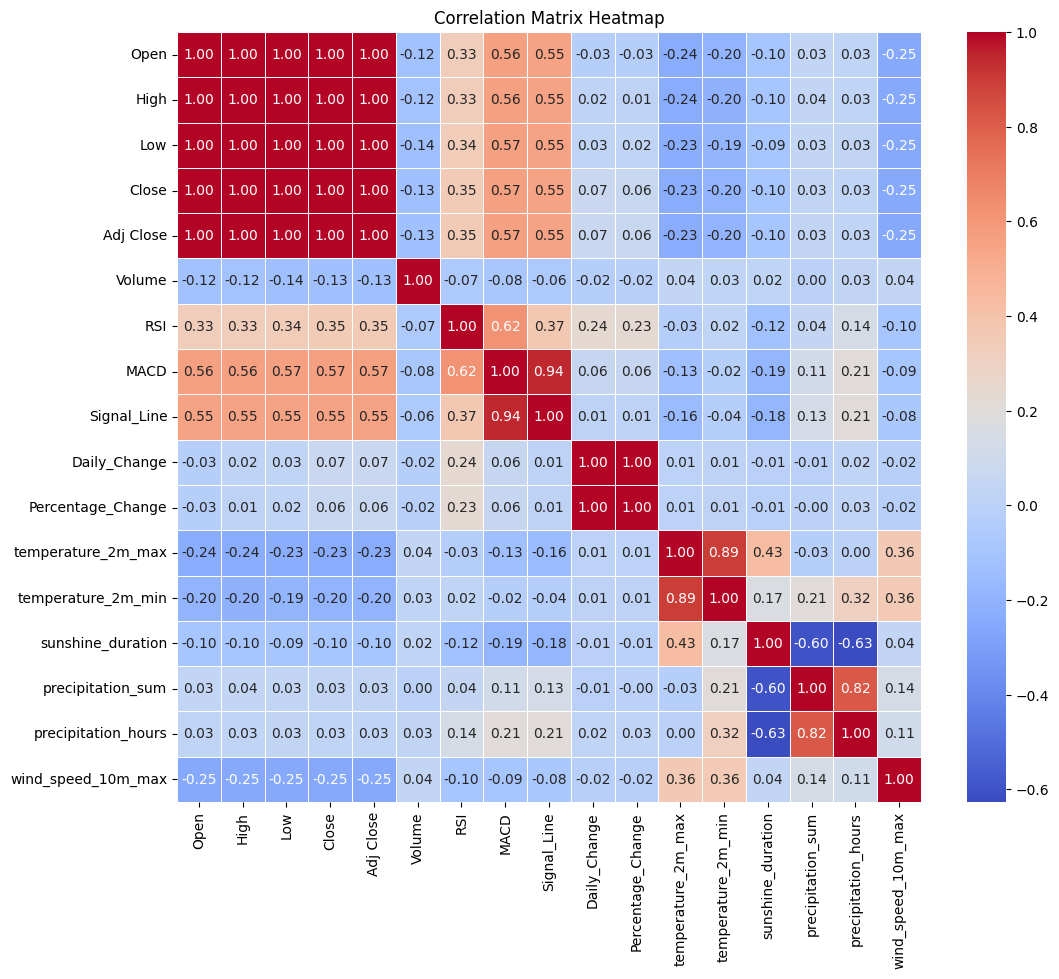

In [ ]:
numeric_data = merged_dataframe.drop(columns=['Date'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
features = ['temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 'precipitation_sum', 'precipitation_hours']
target = ['Open', 'Close']

X2 = merged_dataframe[features]
y2 = merged_dataframe[target]

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Normalize/Standardize the features
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
import numpy as np

# Define the ModelWrapper class
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions.astype(int)  # Ensuring predictions are integers

# Assuming merged_dataframe is your DataFrame
# Define features and target
features = ['temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 'precipitation_sum', 'precipitation_hours']
target = ['Open', 'Close']

X2 = merged_dataframe[features]
y2 = merged_dataframe[target]

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model2 = xgb.XGBRegressor()
xgb_model2.fit(X_train2, y_train2)

# Wrap the model
wrapped_model2 = ModelWrapper(xgb_model2)

# Save the wrapped model
model_filename2 = 'wrapped_xgb_model_with_int_predictions.joblib'
joblib.dump(wrapped_model2, model_filename2)

# Verify the type and class of predictions
predictions2 = wrapped_model2.predict(X_test2)
print(f"Predictions: {predictions2}")
print(f"Type of predictions: {type(predictions2)}")
print(f"Class of first prediction: {type(predictions2[0])}")


Predictions: [[17302 17248]
 [17216 17005]
 [17630 17741]
 [19528 19655]
 [17740 17577]
 [18542 18220]
 [18471 18134]
 [17413 17715]
 [17587 17689]
 [17835 17992]
 [15984 16286]
 [17823 17993]
 [18071 18031]
 [17124 16969]
 [15951 15784]
 [18602 18207]
 [18239 18482]
 [17233 17088]
 [17216 17720]
 [20077 21096]
 [18357 18477]
 [17520 17721]
 [20921 20931]
 [18330 17288]
 [18085 17921]
 [16457 16186]
 [18701 17797]
 [19054 19264]
 [16669 17018]
 [17555 17651]
 [18681 18564]
 [16819 16923]
 [18902 18890]
 [18460 18729]
 [16552 17389]
 [15529 15752]
 [18203 18298]
 [16905 16964]
 [18682 18720]
 [17134 17391]
 [17127 17117]
 [19320 18991]
 [17866 17452]
 [17056 16678]
 [21649 21455]
 [17892 18311]
 [18692 18538]
 [17226 17532]
 [16154 16540]
 [18830 19049]
 [19110 19588]
 [18085 18212]
 [18324 18818]
 [16823 16882]
 [17194 17339]
 [19071 19006]
 [19250 19354]
 [18295 18416]
 [18023 17812]
 [17358 17756]
 [16291 17128]
 [17879 17041]
 [17833 18566]
 [17427 17503]
 [18670 18715]
 [17911 1755

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.multioutput import MultiOutputRegressor

In [ ]:
# # Example using XGBoost
# xgb_model = MultiOutputRegressor(XGBRegressor())
# xgb_model.fit(X_train_scaled2, y_train2)
# xgb_predictions = xgb_model.predict(X_test_scaled2)


In [ ]:
# def evaluate_multioutput_model(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
#     mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
#     r2 = r2_score(y_true, y_pred, multioutput='raw_values')
#     return mse, mae, r2

In [ ]:
# # Example evaluation for one of the models
# mse, mae, r2 = evaluate_multioutput_model(y_test2, xgb_predictions)
# print(f'XGBoost - MSE: {mse}, MAE: {mae}, R²: {r2}')

In [ ]:
def predict_open_close(model, temperature_2m_max, temperature_2m_min, sunshine_duration, precipitation_sum, precipitation_hours):
    # Create a DataFrame with the input data
    input_data = pd.DataFrame({
        'temperature_2m_max': [temperature_2m_max],
        'temperature_2m_min': [temperature_2m_min],
        'sunshine_duration': [sunshine_duration],
        'precipitation_sum': [precipitation_sum],
        'precipitation_hours': [precipitation_hours]
    })

    # Predict the Open and Close values
    predicted_values = model.predict(input_data)

    # Convert the output to integer type and calculate the range
    open_close_range = int(predicted_values[0][1] - predicted_values[0][0])

    return open_close_range


In [ ]:
import pandas as pd
import joblib

# Load the wrapped model
loaded_model2 = joblib.load('wrapped_xgb_model2.pkl')

# Example input values
temperature_2m_max = 30.0
temperature_2m_min = 20.0
sunshine_duration = 10.0
precipitation_sum = 0.5
precipitation_hours = 2.0

# Predict the open-close difference
difference = predict_open_close(loaded_model2, temperature_2m_max, temperature_2m_min, sunshine_duration, precipitation_sum, precipitation_hours)

# Print the difference between predicted close and open values
print(f"Predicted Open-Close range: {difference}")


FileNotFoundError: [Errno 2] No such file or directory: 'wrapped_xgb_model2.pkl'

In [ ]:
# import joblib
# import pandas as pd

# # Load the trained model (assuming 'wrapped_xgb_model2.pkl' is your existing model file)
# loaded_model = joblib.load('wrapped_xgb_model_with_int_predictions.joblib')

# # Verify the type and class of predictions (optional)
# # You can uncomment this part to check the predictions if needed
# # features = ['temperature_2m_max', 'temperature_2m_min', 'sunshine_duration', 'precipitation_sum', 'precipitation_hours']
# # example_input = pd.DataFrame({
# #     'temperature_2m_max': [30.0],
# #     'temperature_2m_min': [20.0],
# #     'sunshine_duration': [10.0],
# #     'precipitation_sum': [0.5],
# #     'precipitation_hours': [2.0]
# # })
# # predictions = loaded_model.predict(example_input)
# # print(f"Predictions: {predictions}")
# # print(f"Type of predictions: {type(predictions)}")
# # print(f"Class of first prediction: {type(predictions[0][0])}")

# # Save the model as a pickle file
# model_filename = 'wrapped_xgb_model_with_int_predictions.joblib'
# joblib.dump(loaded_model, model_filename)

# # Optional: If you're using Google Colab and want to download the file to your local machine
# from google.colab import files
# files.download(model_filename)


In [ ]:
# import joblib

In [ ]:
# # Assuming model is your trained model and scaler is your fitted scaler
# model_filename = 'xgb_model.pkl'
# # Save model
# joblib.dump('xgb', model_filename)

# # Download files if needed (to your local machine)
# from google.colab import files
# # files.download(model_filename)

In [ ]:
# import joblib

# # Load the pickle file
# loaded_model = joblib.load('wrapped_xgb_model_with_int_predictions.joblib')

# # Check the class/type of the loaded model
# print(f"Type of loaded model: {type(loaded_model)}")
# print(f"Class of loaded model: {loaded_model.__class__.__name__}")
